In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
import scipy
import scipy.linalg
from Utility import data_collecter
import os
from Utility import DerivativeLiftFunc, data_collecter,RBFLiftFunc
import lqr

/home/stone/anaconda3/envs/mujoco/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [2]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
                ]
method_index = 1
# suffix = "CartPole1_26"
# env_name = "CartPole-v1"
# suffix = "Pendulum1_26"
# env_name = "Pendulum-v1"
# suffix = "DampingPendulum1_26"
# env_name = "DampingPendulum"
suffix = "MountainCarContinuous1_26"
env_name = "MountainCarContinuous-v0"
suffix = "TwoLinkRobot2_9"
env_name = "TwoLinkRobot"

In [3]:
Data = np.load("Prediction_Results/"+"Kd_"+env_name+"_KoopmanRBF"+".npz")
Kd = Data["Kd"]
center = Data["Center"]
Data_collecter = data_collecter(env_name)
Nstate = Data_collecter.Nstates
udim = Data_collecter.udim
Nrbf = 50
LiftFunc = RBFLiftFunc(env_name,Nstate,udim,Nrbf,Data_collecter.observation_space,center=center)
NKoopman = LiftFunc.NKoopman

In [4]:

def Prepare_LQR(env_name):
    x_ref = np.zeros(Nstate)
    if env_name.startswith("CartPole"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[1,1] = 0.01
        Q[2,2] = 5.0
        Q[3,3] = 0.01
        R = 0.001*np.eye(1)
        reset_state=  [0.0,0.0,-1.0,0.1]
    elif env_name.startswith("Pendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.01*np.eye(1)
        reset_state = [-3.0,6.0]
    elif env_name.startswith("DampingPendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 100*np.eye(1)
        reset_state = [-3.0,2.0]   
    elif env_name.startswith("MountainCarContinuous"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 0.01*np.eye(1)
        reset_state = [-0.3,0.1]  
        x_ref[0] = 0.45
    elif env_name.startswith("TwoLinkRobot"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[:2,:2] = 5*np.eye(2)
        Q[2:4,2:4] = 0.01*np.eye(2)
        R = np.eye(2)
        x_ref[0] = np.pi/2.0
        x_ref[1] = 0.0
        reset_state = [0,0,0,0]
    Q = np.matrix(Q)
    R = np.matrix(R)
    return Q,R,reset_state,x_ref
    
def criterion(env_name,observations):
    if env_name.startswith("CartPole"):
        err = np.mean(abs(observations[2:,195:]))
    elif env_name.startswith("Pendulum"):
        err = np.mean(abs(observations[:,195:]))
    elif env_name.startswith("DampingPendulum"):
        err = np.mean(abs(observations[:,195:]))
    elif env_name.startswith("MountainCarContinuous"):
        err = np.mean(abs(observations[0,195:]-0.45))+np.mean(abs(observations[1,195:]))
    elif env_name.startswith("TwoLinkRobot"):
        err = np.mean(abs(observations[:,195:]-np.array([np.pi/2.0,0.0,0,0]).reshape(-1,1)))
    return err

def Cost(observations,u_list,Q,R,x_ref):
    steps = observations.shape[1]
    loss = 0
    for s in range(steps):
        if s!=steps-1:
            ucost = np.dot(np.dot(u_list[s].T,R),u_list[s])
            loss += ucost[0,0]
        xcost = np.dot(np.dot((observations[:,s]-x_ref).T,Q),(observations[:,s]-x_ref))
        loss += xcost[0,0]
    return loss

/home/stone/anaconda3/envs/mujoco/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D-01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.1000000000000D-01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the mach

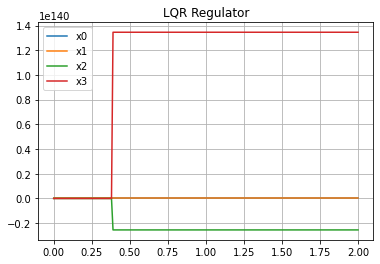

In [5]:
Ad = Kd[:NKoopman,:NKoopman]
Bd = Kd[:NKoopman,NKoopman:]
env = Data_collecter.env
env.reset()
import lqr
import time
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)
reset_state=  [0.1,0.1,0.0,0.0]
uval = 0.0001 
Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,uval*R)
observation_list = []
observation = np.array(env.reset_state(reset_state))
x0 = np.matrix(LiftFunc.Psi_s(observation)).reshape(NKoopman,1)
x_ref_lift = LiftFunc.Psi_s(x_ref).reshape(NKoopman,1)
observation_list.append(x0[:Nstate].reshape(-1,1))
# print(Kopt)
u_list = []
steps = 200
# umax = 100
for i in range(steps):
    u = -Kopt*(x0-x_ref_lift)
    observation, reward, done, info = env.step(u.reshape(-1))
    x0 = np.matrix(LiftFunc.Psi_s(observation)).reshape(NKoopman,1)
    observation_list.append(x0[:Nstate].reshape(-1,1))
    u_list.append(u)
observations = np.concatenate(observation_list,axis=1)
u_list = np.array(u_list).reshape(-1)
np.save("SingleControlResults/"+env_name+"_KoopmanRBF_obs.npy",observations)
Err = criterion(env_name,observations)
loss = Cost(observations,u_list,Q[:Nstate,:Nstate],0.0*R,x_ref)
print(Err,loss)
time_history = np.arange(steps+1)*env.dt
for i in range(Nstate):
    plt.plot(time_history, observations[i,:].reshape(-1,1), label="x{}".format(i))
plt.grid(True)
plt.title("LQR Regulator")
plt.legend()
plt.savefig("SingleControlResults/"+env_name+"_KoopmanRBF.png")
plt.show()